# Studying the behavior of deeper multilayer perceptron
Here more than 1 hidden layers were implemented in order to compare its extrapolative behavior to that of a single layer MLP. Conclusively, the change in the depth of MLP does not change the behavior on spiral and sxor datasets in the range of [0, 3].

In [1]:
# changing cwd
%cd ..

c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias


## Load packages

In [2]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf\SimulationData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf\PosteriorData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf\TrainedCLF.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf\EstimatedData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf\HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


In [3]:
#load multilayer MLP data
ib.load_MLPs()

[ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf\MLPData.pickle ] loaded


## Time and Date of the experiment

In [4]:
print(ib.date)

2021-09-08 03:24:29.410870


## Load Dependencies

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
# import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from mpl_toolkits.axes_grid1 import AxesGrid

cmap = 'PRGn'

# for figure 3
import matplotlib as mpl
from matplotlib.lines import Line2D #only for the purpose of creating the legend

import warnings
warnings.filterwarnings('ignore')

## Setting masking grid to match the grid used for human experiment

In [6]:
ib.mask = ib.generate_mask(h=0.1)
ib.mask.shape

(3600, 2)

## Training multilayer MLPs
training separate MLPs with [1,2,4,8] hidden layers with 100 neurons in each layer

In [7]:
ib.get_MLPs(save=True)

layer:   0%|          | 0/4 [00:00<?, ?it/s]

User sequence match and dataframe exported


layer: 100%|██████████| 4/4 [33:15<00:00, 498.91s/it]

saving current attributes..
completed after 0 seconds
saved as [ c:\Users\jongm\Desktop\temp_workspace\JOVO\inductive-bias\clf\MLPData.pickle ]


In [36]:
#generic global
uX = ib.mask #3600 points
uX0, uX1 = uX[:,0], uX[:,1]

# ib.mask = ib.generate_mask(rng=4.3) #739.6k points
label = ib.mtype[:3] + ['Human'] #excluding QDA
label[0] = 'SVM (radial)'
label2 = ['1 layer','2 layer','4 layer','8 layer'] #label for multilayer MLPs
dtype = ib.dtype[2:5:2]
fsize = 18

#figure
SAVEFIG = False
FILENAME = '20210907_deeper_network'

## Point-wise averaging and gaussian smoothing estimated posterior
As demonstrated previously, these operations allow for apple to apple comparison between ML and humans, after which the grid coordinates exactly match between ML and human

In [22]:
mtype = []

for ii in range(2): #S-XOR and spiral
    mtype.append([])
    
    for jj in range(5):
        if jj == 4:
            mtype_i = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5], ib.human[ii][:,0]]) # human estimates
        else:
            mtype_i = ib.mlps[ii][jj] # ML estimates
        
        mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()
        xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method=None, sigma=1, k=10)
        mtype[ii].append(alls)

## Compute Hellinger Distance between ML and humans
The metric for comparison is a point-wise hellinger distance

In [23]:
hdists = []

for row in range(2):
    hdists.append([])
    for col in range(5):
        hdists[row].append(ib._hellinger_explicit(mtype[row][col], mtype[row][4]))

## Visualization of spiral class 1 poserior of different depth of MLPs

In [29]:
mtype[0][0]

array([0.20652371, 0.09955825, 0.02649125, ..., 0.84139058, 0.9480625 ,
       0.95958261])

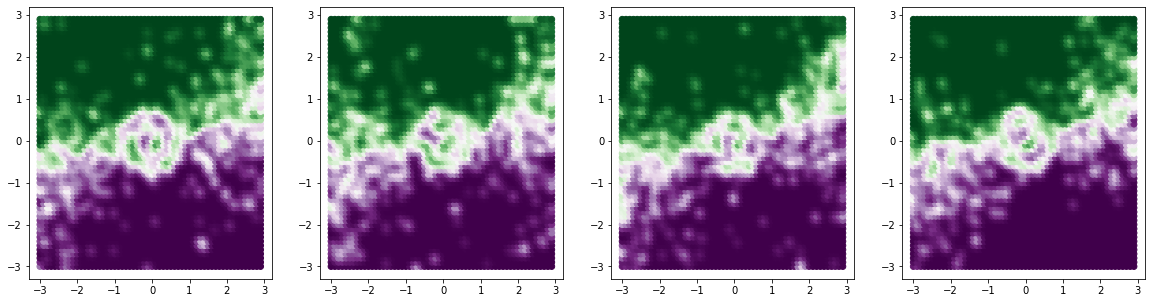

In [31]:
fig, ax = plt.subplots(1,4, figsize=(5*4,5))

for i in range(4):
    ax[i].scatter(x=ib.mask[:,0],y=ib.mask[:,1],c=mtype[0][i], cmap=cmap)

## Visualization of S-XOR class 1 poserior of different depth of MLPs

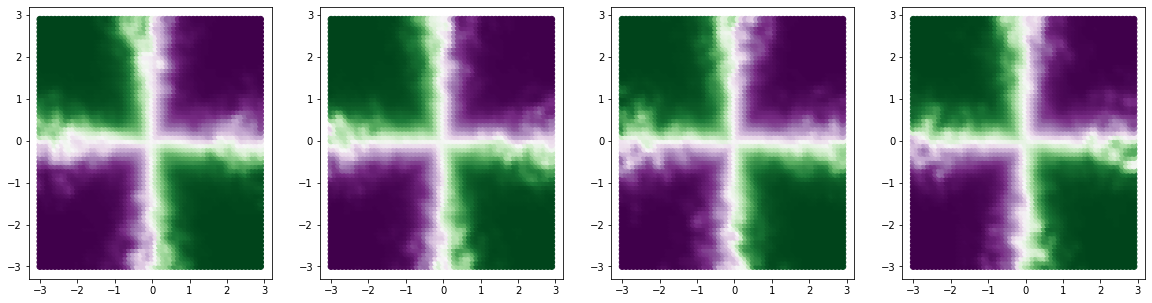

In [32]:
fig, ax = plt.subplots(1,4, figsize=(5*4,5))

for i in range(4):
    ax[i].scatter(x=ib.mask[:,0],y=ib.mask[:,1],c=mtype[1][i], cmap=cmap)

## Qualitative figure of the hellinger distance against human posterior

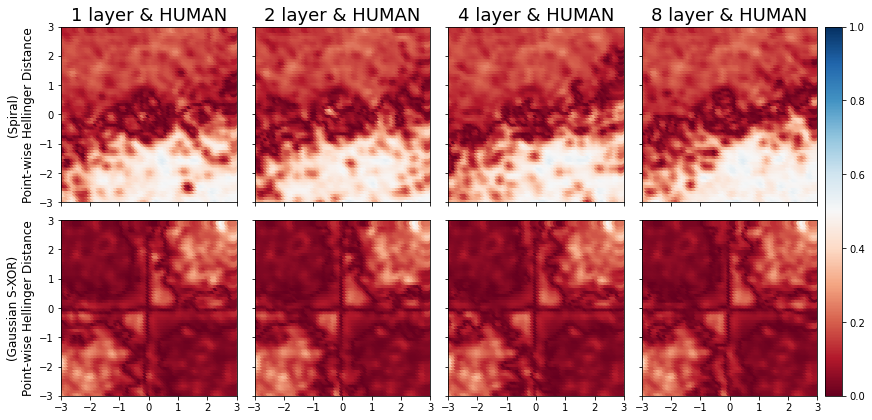

In [39]:
for i_scheme, diff_col_scheme in enumerate(['RdBu']):

    fig = plt.figure(figsize=(7*2, 7*4))

    grid = AxesGrid(fig, 111,
                    nrows_ncols=(2, 4),
                    axes_pad=0.25,
                    cbar_mode='single',
                    cbar_location='right',
                    cbar_pad=0.1
                    )

    idx = 0

    for ax in grid:
        row = idx // 4
        col = idx % 4
        # ax.set_axis_off()
        mlp = ax.scatter(ib.mask[:,0], ib.mask[:,1], c=hdists[row][col], cmap=diff_col_scheme, vmin=0, vmax=1) #np.array(hdists).max().round(1)) #consistent colorbar range (0-1)

        if row == 0:
            ax.set_title(label2[col] + ' & HUMAN', fontsize=fsize)

        if col == 0:
            # ax.set_ylabel(dtype[row], fontsize=fsize)
            ax.set_ylabel(f'({dtype[row]})\nPoint-wise Hellinger Distance', fontsize=fsize-6)

        ax.set_xlim([-3,3])
        ax.set_ylim([-3,3])
        ax.set_yticks(np.arange(-3,4))
        ax.set_xticks(np.arange(-3,4))
        
        idx += 1

    cbar = ax.cax.colorbar(mlp)
    cbar.ax.set_yticks(np.arange(0, 1.1, 0.5))

# fig.suptitle("Hellinger Distance against human prediction", y=0.72, fontsize=25)

    if SAVEFIG:
        plt.savefig(f'figs/[{FILENAME}]_hidden_layers_{str(ib.date.date())}.jpg', bbox_inches='tight')

plt.show()

## Quantitative figure of the hellinger distance against human posterior

In [42]:
angle_step = 12 #default = 12
fdtype = ['spiral', 'sxor'] #dtype defined for filename

palette = sns.color_palette('bright', len(ib.mtype))

col = 1
row = 1

step = 0.2
r = 4
x_range = np.arange(-r,r,step)
angles = np.arange(0, 180+angle_step, angle_step)
# angles = np.array([0,180]) #just to check to see if 0 and 180 yields the same results

line_plots = []
line_posts = []

for deg in tqdm(angles):

    line_plot = []
    line_post = []

    #selecting linear region of interest over hellinger distance at given degree of angle
    for i in tqdm(range(2), leave=False):
        line_plot.append([])
        line_post.append([])

        for j in range(4):
            line_plot[i].append([])
            line_post[i].append(ib.select_linear_region(hdists[i][j], degree=deg, step=0.001))
            
            lp, li = line_post[i][j] #line posterior, line index
            x = ib.mask[li][:,0]
            y = ib.mask[li][:,1]
            dist = np.sqrt(x**2 + y**2)

            dist[y < 0] *= -1 # negative radial distance wrt y-coordinate

            for rad in x_range:
                line_plot[i][j].append(np.array(lp[(dist >= rad) * (dist < rad+step)]).mean())

    line_plots.append(line_plot)
    line_posts.append(line_post)

100%|██████████| 16/16 [00:42<00:00,  2.64s/it]


In [43]:
# n x m x o x p multidimentional matrix where n is N_angle, m is N_data, o is N_algo, and p is N_rad
line_plots = np.array(line_plots)
line_plots.shape

(16, 2, 4, 40)

In [44]:
lp_temp = np.swapaxes(line_plots,0,1)
lp_temp[0,:,0].shape

(16, 40)

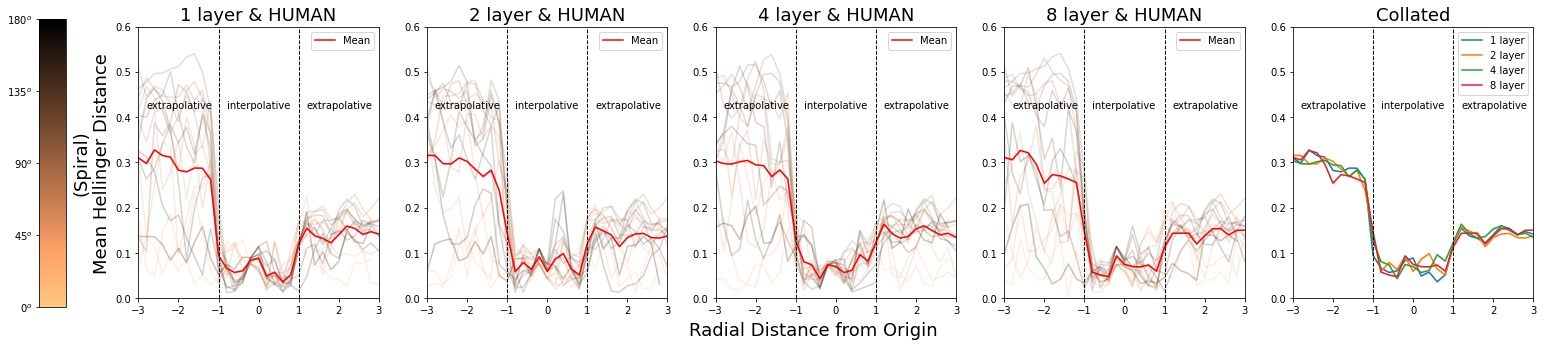

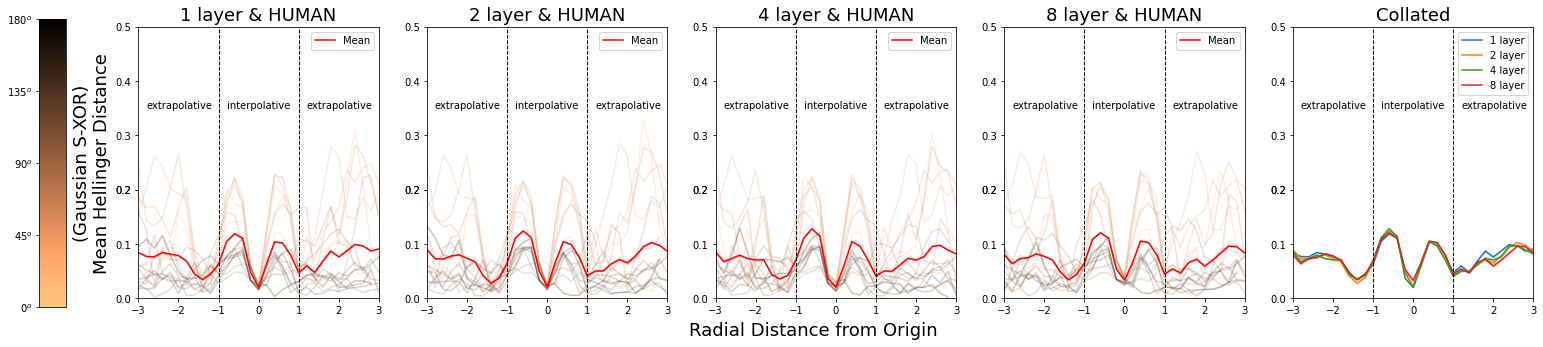

In [49]:
mpl.rcParams['text.usetex'] = False

panel_num = 5
mean_lines = []

for j, dt in enumerate(dtype):

    fig, ax = plt.subplots(1, panel_num, figsize=[5*panel_num, 5])
    plt.locator_params(axis="y", nbins=5)
    t_ylim = 0
    mean_lines.append([])

    for i in range(panel_num):

        if i == 4:
            #last panel
            for line in range(len(mean_lines[j])):
                mpl_lp = sns.lineplot(data=mean_lines[j][line], x='rad', y='value', ci=0, ax=ax[i], label=label2[line])#, color='red')
            ax[i].set_title('Collated', fontsize=fsize)
            ax[i].set_xlim([-3,3])
        else:
            #calculating individual lines
            tempdf = pd.DataFrame(lp_temp[j,:,i])
            tempdf.columns = x_range

            if round(tempdf.max().max(),1) > t_ylim:
                t_ylim = round(tempdf.max().max()+0.05,1)

            sns.lineplot(data=tempdf.T, ax=ax[i], palette='copper_r', alpha=0.2, dashes=None)#, dashes=[(1,1) for i in range(len(angles))])

            ax[i].set_title(label2[i] + ' & HUMAN', fontsize=fsize)
            ax[i].set_xlim([-3,3])

            #calculating the average
            tempdf = pd.DataFrame(lp_temp[j,:,i])
            tempdf.columns = x_range
            tempdf2 = tempdf.T
            tempdf2['rad'] = tempdf.T.index.to_numpy()
            tempdf2.columns = [f'{i}' for i in range(len(angles))] + ['rad']
            tempdf3 = tempdf2
            tempdf3 = pd.melt(tempdf3, 'rad')
            mean_lines[j].append(tempdf3)

            sns.lineplot(data=tempdf3, x='rad', y='value', ci=0, ax=ax[i], color='red')

        if i != 4:
            ax[i].legend().remove()
            ax[i].legend([Line2D([0], [0], color='red')], ['Mean'])#, bbox_to_anchor=(3.7+1.2,0.58))
        # else:
            # ax[i].legend(angles, bbox_to_anchor=(3.7,0.98), title='Angles') #depreciated (adds complete list of angles)

    for i in range(panel_num):
        ax[i].set_ylim([0, t_ylim])
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].yaxis.set_ticks(np.linspace(0, t_ylim, num=7).round(1))
        ax[i].axvline(x=1, lw=1, ls='--', color='black')
        ax[i].axvline(x=-1, lw=1, ls='--', color='black')
        temp_ylim = ax[i].get_ylim()[1] * 0.7
        ax[i].text(-0.8,temp_ylim,'interpolative',fontsize=10)
        ax[i].text(-2.8,temp_ylim,'extrapolative',fontsize=10)
        ax[i].text(1.2,temp_ylim,'extrapolative',fontsize=10)

    # left colorbar specification
    tick_n = 5
    mpl.rcParams['text.usetex'] = True #throws an error when globally activated
    ticks = [i + r'$^{o}$' for i in np.linspace(0, 180, tick_n).astype(int).astype(str)]
    mpl.rcParams['text.usetex'] = False
    
    cax = plt.axes([0.07, 0.1, 0.015, 0.8])
    cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='copper_r'), cax=cax)

    # parameters need to be set after colorbar is generated
    cax.yaxis.set_label_position('left')
    cax.yaxis.set_ticks_position('left')
    cbar.ax.locator_params(nbins=tick_n-1)
    cax.yaxis.set_ticklabels(ticks)

    ax[0].set_ylabel(f'({dt})\nMean Hellinger Distance', fontsize=fsize)
    fig.supxlabel('Radial Distance from Origin', fontsize=fsize)

    if SAVEFIG:
        plt.savefig(f'figs/[{FILENAME}]_hidden_hellinger_{dtype[j]}_{str(ib.date.date())}.jpg', bbox_inches='tight')